In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm
from collections import OrderedDict
from multiprocessing.pool import Pool
from multiprocessing import cpu_count
import time

### Load Dataset

In [2]:
covariates = ["age", "workclass", "education", "marital-status", "occupation", 
              "race", "sex", "hours-per-week"]
outcome = "outcome"


# data containing categorical features
mdscan_data = pd.read_csv("datasets/adult/test.data")
mdscan_data["outcome"] = (mdscan_data["outcome"] == " >50K.").astype(np.int)

### Define Classifiers

In [3]:
classifiers_labels = [
    "LogisticRegression",
    "RandomForestClassifier",
    "SVC",
    "KNeighborsClassifier",
    "MLPClassifier"
]

In [4]:
domains = {}

for cov in covariates:
    domains[cov] = np.unique(mdscan_data[cov])
    
observed = 'outcome'
expected = 'proba' 

### Test 1

In [5]:
def experiment1(p, i, seed):
    np.random.seed(seed)
    results = {}
    
    for clf_label in classifiers_labels:
        # load probability column for the current experiment
        filename = "training/test1/clf=%s_p=%d_i=%d.pkl" % (clf_label, p, i)
        file = open(filename, 'rb')
        proba = pkl.load(file)
        file.close()
        
        outcome = mdscan_data[observed].to_numpy()
        results[clf_label] = roc_auc_score(outcome, proba)
        
    return results

In [5]:
percentages = [1, 2, 4, 8, 16, 32]

In [7]:
num_experiments = 7
results = {}
acc = {}

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)

for p in percentages:
    results[p] = {}
    acc[p] = []
    seeds = np.random.randint(0, 99999, size=num_experiments)
    
    for i in range(num_experiments):
        acc[p].append(pool.apply_async(experiment1, (p, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()

for p in percentages:
    # collect the results
    acc[p] = [res.get() for res in acc[p]]
    
    for clf_label in classifiers_labels:
        for res in acc[p]:
            results[p][clf_label] = results[p].get(clf_label, []) + [res[clf_label]]
            
# print duration
print("Ellapsed: %.2f" % (time.time() - start))

Ellapsed: 0.17


In [8]:
# save results
file = open("./results/auc_test1.pkl", 'wb')
pkl.dump(results, file)
file.close()

In [6]:
results = pkl.load(open("./results/auc_test1.pkl", 'rb'))
statistics = {}

for p in results:
    for clf in classifiers_labels:
        scores = results[p][clf]
        mean_score = np.mean(scores)
        stdev_score = np.std(scores)
        statistics[clf] = statistics.get(clf, []) + [[mean_score, stdev_score]]

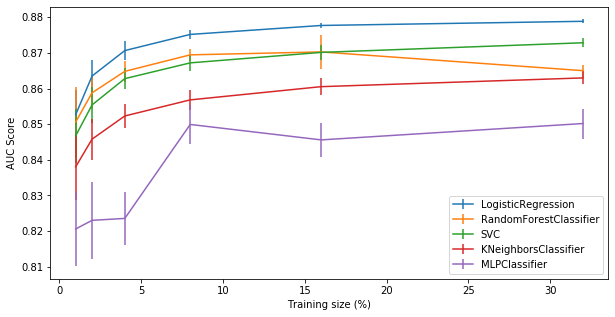

In [7]:
plt.figure(figsize=(10, 5))

for clf in classifiers_labels:
    y = np.array(statistics[clf])
    plt.errorbar(percentages, y[:, 0], yerr=y[:, 1])

plt.legend(classifiers_labels)
plt.xlabel("Training size (%)")
plt.ylabel("AUC Score")
plt.show()

### Test 2

In [11]:
def experiment2(nc, i, seed):
    np.random.seed(seed) 
    results = {}

    for clf_label in classifiers_labels:
        # load probability column for the current experiment
        filename = "./training/test2/clf=%s_nc=%d_i=%d.pkl" % (clf_label, nc, i)
        file = open(filename, 'rb')
        proba = pkl.load(file)
        file.close()
        
        outcome = mdscan_data[observed].to_numpy()
        results[clf_label] = roc_auc_score(outcome, proba)
        
    return results

In [8]:
num_covariates = [1, 2, 3, 4, 5]

In [13]:
num_experiments = 7
results = {}
acc = {}

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)

for nc in num_covariates:
    results[nc] = {}    
    acc[nc] = []
    seeds = np.random.randint(0, 99999, size=num_experiments)
    
    for i in range(num_experiments):
        acc[nc].append(pool.apply_async(experiment2, (nc, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()

for nc in num_covariates:
    # collect the results
    acc[nc] = [res.get() for res in acc[nc]]
    
    for clf_label in classifiers_labels:
        for res in acc[nc]:
            results[nc][clf_label] = results[nc].get(clf_label, []) + [res[clf_label]]
            
# print duration
print("Ellapsed: %.2f" % (time.time() - start))

Ellapsed: 0.17


In [14]:
# save results
file = open("./results/auc_test2.pkl", 'wb')
pkl.dump(results, file)
file.close()

In [9]:
results = pkl.load(open("./results/auc_test2.pkl", 'rb'))
statistics = {}

for nc in results:
    for clf in classifiers_labels:
        scores = results[nc][clf]
        mean_score = np.mean(scores)
        stdev_score = np.std(scores)
        
        buffer = statistics.get(clf, [])
        statistics[clf] = buffer + [[mean_score, stdev_score]]

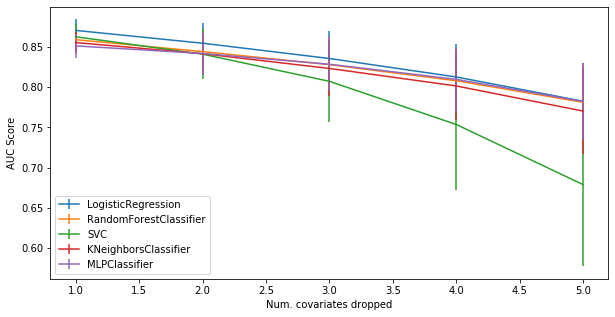

In [10]:
plt.figure(figsize=(10, 5))

for clf in classifiers_labels:
    y = np.array(statistics[clf])
    plt.errorbar(num_covariates, y[:, 0], yerr=y[:, 1])

plt.legend(classifiers_labels)
plt.xlabel("Num. covariates dropped")
plt.ylabel("AUC Score")
plt.show()

### Test 3

In [17]:
def experiment3(p, i, seed):
    np.random.randint(seed)
    results = {}
   
    for clf_label in classifiers_labels:
        # load probability column for the current experiment
        filename = "./training/test3/clf=%s_p=%d_i=%d.pkl" % (clf_label, p, i)
        file = open(filename, 'rb')
        proba = pkl.load(file)
        file.close()
        
        outcome = mdscan_data[observed].to_numpy()
        results[clf_label] = roc_auc_score(outcome, proba)
    
    return results

In [11]:
percentages = [1, 2, 4, 8, 16, 32]

In [19]:
num_experiments = 7
results = {}
acc = {}

# transform categorical variables into dummy
train_data = pd.get_dummies(mdscan_data, prefix=covariates, columns=covariates)

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)

for p in percentages:
    results[p] = {}    
    acc[p] = []
    seeds = np.random.randint(0, 99999, size=num_experiments)
    
    for i in range(num_experiments):
        acc[p].append(pool.apply_async(experiment3, (p, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()

for p in percentages:
    # collect the results
    acc[p] = [res.get() for res in acc[p]]
    
    for clf_label in classifiers_labels:
        for res in acc[p]:
            results[p][clf_label] = results[p].get(clf_label, []) + [res[clf_label]]
            
# print duration
print("Ellapsed: %.2f" % (time.time() - start))

Ellapsed: 0.14


In [20]:
# save results
file = open("./results/auc_test3.pkl", 'wb')
pkl.dump(results, file)
file.close()

In [12]:
results = pkl.load(open("./results/auc_test3.pkl", 'rb'))
statistics = {}

for p in results:
    for clf in classifiers_labels:
        scores = results[p][clf]
        mean_score = np.mean(scores)
        stdev_score = np.std(scores)
        
        buffer = statistics.get(clf, [])
        statistics[clf] = buffer + [[mean_score, stdev_score]]

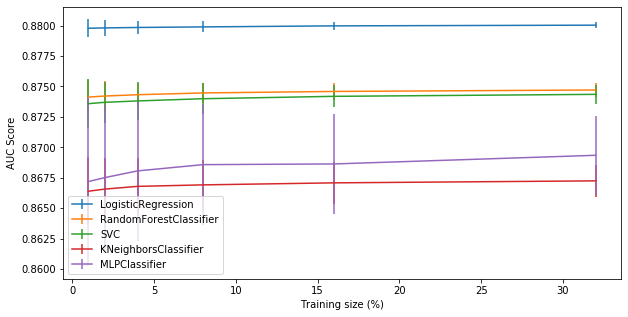

In [13]:
plt.figure(figsize=(10, 5))

for clf in classifiers_labels:
    y = np.array(statistics[clf])
    plt.errorbar(percentages, y[:, 0], yerr=y[:, 1])

plt.legend(classifiers_labels)
plt.xlabel("Training size (%)")
plt.ylabel("AUC Score")
plt.show()

### Test 4

In [23]:
def experiment4(q, i, seed):
    np.random.seed(seed)
    results = {}
   
    for clf_label in classifiers_labels:
        # load outcome, probability and affected sub-population for the current experiment
        filename = "./training/test4/clf=%s_q=%.2f_i=%d.pkl" % (clf_label, q, i)
        file = open(filename, 'rb')
        proba, s_affected = pkl.load(file)
        file.close()
        
        outcome = mdscan_data[observed].to_numpy()
        results[clf_label] = roc_auc_score(outcome, proba)
        
    return results

In [14]:
qs = [.9, .7, .5, .3, .1]

In [25]:
num_experiments = 7
results = {}

# transform categorical variables into dummy
train_data = pd.get_dummies(mdscan_data, prefix=covariates, columns=covariates)

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)
    
for q in qs:
    results[q] = {}    
    acc[q] = []
    seeds = np.random.randint(0, 99999, size=num_experiments)
    
    for i in range(num_experiments):
        acc[q].append(pool.apply_async(experiment4, (q, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()


for q in qs:
    # collect the results
    acc[q] = [res.get() for res in acc[q]]
    
    for clf_label in classifiers_labels:
        for res in acc[q]:
            results[q][clf_label] = results[q].get(clf_label, []) + [res[clf_label]]
            
# print duration
print("Ellapsed: %.2f" % (time.time() - start))

Ellapsed: 0.14


In [26]:
# save results
file = open("./results/auc_test4.pkl", 'wb')
pkl.dump(results, file)
file.close()

In [15]:
score_results = pkl.load(open("./results/auc_test4.pkl", 'rb'))
statistics = {}

for q in score_results:
    for clf in classifiers_labels:
        scores = score_results[q][clf]
        mean_score = np.mean(scores)
        stdev_score = np.std(scores)
        
        buffer = statistics.get(clf, [])
        statistics[clf] = buffer + [[mean_score, stdev_score]]

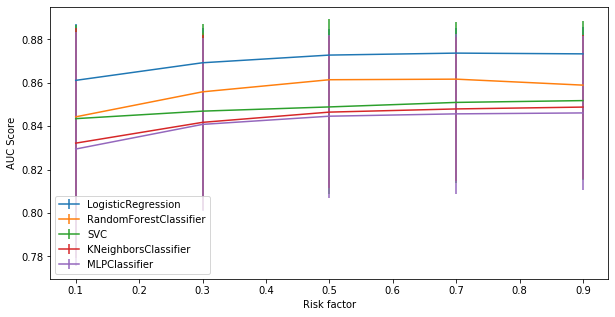

In [16]:
plt.figure(figsize=(10, 5))

for clf in classifiers_labels:
    y = np.array(statistics[clf])
    plt.errorbar(qs, y[:, 0], yerr=y[:, 1])

plt.legend(classifiers_labels)
plt.xlabel("Risk factor")
plt.ylabel("AUC Score")
plt.show()

### Test 5

In [29]:
def experiment5(cov, i, seed):
    np.random.seed(seed)
    results = {}
    
    for clf_label in classifiers_labels:
        # load probability column
        filename = "./training/test5/clf=%s_cov=%s_i=%d.pkl" % (clf_label, cov, i)
        file = open(filename, 'rb')
        proba = pkl.load(file)
        file.close()
        
        outcome = mdscan_data[observed].to_numpy()
        results[clf_label] = roc_auc_score(outcome, proba)

    return results

In [30]:
num_experiments = 7
num_rows = mdscan_data.shape[0]
results = {}
acc = {}

# start time
start = time.time()

# define thread pool
pool = Pool(processes=cpu_count() - 1)

extended_cov = [None] + covariates
for cov in extended_cov:
    results[cov] = {}
    seeds = np.random.randint(0, 99999, size=num_experiments)
    acc[cov] = []
    
    for i in range(num_experiments):
        acc[cov].append(pool.apply_async(experiment5, (cov, i, seeds[i])))
        
# close thread pool & wait for all jobs to be done
pool.close()
pool.join()

for cov in extended_cov:
    # collect the results
    acc[cov] = [res.get() for res in acc[cov]]
    
    for clf_label in classifiers_labels:
        for res in acc[cov]:
            results[cov][clf_label] = results[cov].get(clf_label, []) + [res[clf_label]]
            
# print duration
print("Ellapsed: %.2f" % (time.time() - start))

Ellapsed: 0.16


In [31]:
# save results
file = open("./results/auc_test5.pkl", 'wb')
pkl.dump(results, file)
file.close()

In [18]:
results = pkl.load(open("./results/auc_test5.pkl", 'rb'))
statistics = {}
extended_cov = [None] + covariates

for clf in classifiers_labels:
    statistics[clf] = []
    
    for cov in extended_cov:
        statistics[clf].append(np.mean(results[cov][clf]))

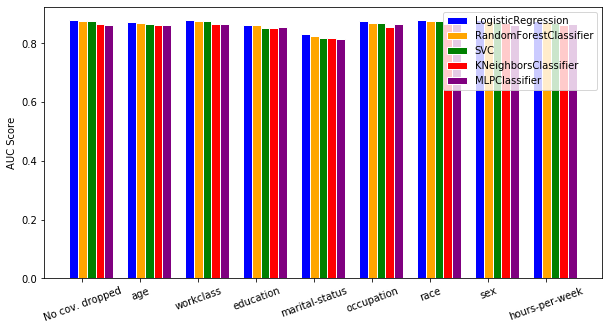

In [19]:
# set width of bar
bar_width = 0.15
 
rs = [np.arange(len(extended_cov))]
for i in range(1, len(classifiers_labels)):
    r = np.array([x + bar_width for x in rs[i - 1]])
    rs.append(r)

colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(10, 5))
# Make the plot
for idx, clf in enumerate(classifiers_labels):
    plt.bar(rs[idx], statistics[clf], color=colors[idx], width=bar_width, edgecolor='white', label=clf)

extended_cov[0] = 'No cov. dropped'
plt.ylabel('AUC Score')
plt.xticks([r + bar_width for r in range(len(rs[0]))], extended_cov, rotation=20)
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [20]:
table = pd.DataFrame(statistics, index=extended_cov)
table

,LogisticRegression,RandomForestClassifier,SVC,KNeighborsClassifier,MLPClassifier
No cov. dropped,0.879751,0.874345,0.874016,0.866161,0.861613
age,0.872206,0.867997,0.865449,0.860701,0.860404
workclass,0.879411,0.873865,0.873255,0.866055,0.864843
education,0.860796,0.861523,0.850100,0.852237,0.856092
marital-status,0.829484,0.825136,0.818657,0.818740,0.814242
occupation,0.875809,0.867897,0.866821,0.856135,0.863775
race,0.879792,0.874229,0.873929,0.865722,0.866532
sex,0.878965,0.874052,0.873054,0.866861,0.862580
hours-per-week,0.875423,0.870184,0.868121,0.862570,0.863522
